<a href="https://colab.research.google.com/github/sebas-melendez/MCC_Progra_Avanzada/blob/main/CD_Projecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Montar Archivo


In [21]:
from google.colab import drive
drive.mount('/content/drive')


csv_file = "/content/drive/MyDrive/FMAT/MCC/1er Semestre/CD/earthquake_data_tsunami.csv"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Cargar el dataframe e importar pandas para trabajarlo

In [22]:
import pandas as pd
print('Cargando archivo:', csv_file)
df = pd.read_csv(csv_file)
print('Shape:', df.shape)
print(df.head())

Cargando archivo: /content/drive/MyDrive/FMAT/MCC/1er Semestre/CD/earthquake_data_tsunami.csv
Shape: (782, 13)
   magnitude  cdi  mmi  sig  nst   dmin   gap    depth  latitude  longitude  \
0        7.0    8    7  768  117  0.509  17.0   14.000   -9.7963    159.596   
1        6.9    4    4  735   99  2.229  34.0   25.000   -4.9559    100.738   
2        7.0    3    3  755  147  3.125  18.0  579.000  -20.0508   -178.346   
3        7.3    5    5  833  149  1.865  21.0   37.000  -19.2918   -172.129   
4        6.6    0    2  670  131  4.998  27.0  624.464  -25.5948    178.278   

   Year  Month  tsunami  
0  2022     11        1  
1  2022     11        0  
2  2022     11        1  
3  2022     11        1  
4  2022     11        1  


#Marcar la variable objetivo y eliminarla del DF


In [23]:
target_candidates = ['tsunami']
TARGET = 'tsunami'

y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])


df_dtypes = X.dtypes
cat_cols = df_dtypes[df_dtypes == 'object'].index.tolist()
X = pd.get_dummies(X, drop_first=True)

#División Test Train 80/20


In [24]:
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(
X, y, test_size=0.2, stratify=y, random_state=42
)
print('Train full shape:', X_train_full.shape, 'Test shape:', X_test.shape)

Train full shape: (625, 12) Test shape: (157, 12)


Importar librerías de los modelos, y Kfolds


In [25]:
import numpy as np

from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score
)

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Normalizar proporciones de tsunami
print("Distribución de 'tsunami' en y_train_full:")
print(y_train_full.value_counts(normalize=True).rename('proportion'))
print(y_train_full.value_counts())

# Definimos los k-folds, a 5 splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Métricas que queremos seguir entre todos los modelos
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}


Distribución de 'tsunami' en y_train_full:
tsunami
0    0.6112
1    0.3888
Name: proportion, dtype: float64
tsunami
0    382
1    243
Name: count, dtype: int64


#Regresión Logística


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def make_logreg():
    return Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            solver='lbfgs',
            n_jobs=-1,
            random_state=42
        ))
    ])

best_model_logreg = None
best_f1_val_logreg = -1.0
fold_results_logreg = []

print("=== Regresión Logística - Validación cruzada manual (5 folds) ===")

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_full, y_train_full), start=1):
    X_tr, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_tr, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

    model = make_logreg()
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_val_pred)
    rec = recall_score(y_val, y_val_pred)
    f1  = f1_score(y_val, y_val_pred)
    roc = roc_auc_score(y_val, y_val_proba)

    fold_results_logreg.append((acc, rec, f1, roc))

    print(f"\nFold {fold}:")
    print(f"  Accuracy: {acc:.3f}")
    print(f"  Recall:   {rec:.3f}")
    print(f"  F1:       {f1:.3f}")
    print(f"  ROC AUC:  {roc:.3f}")

    # Nos quedamos con el mejor fold según F1
    if f1 > best_f1_val_logreg:
        best_f1_val_logreg = f1
        best_model_logreg = model

# Promedios de CV
fold_results_logreg = np.array(fold_results_logreg)
mean_acc_lr, mean_rec_lr, mean_f1_lr, mean_roc_lr = fold_results_logreg.mean(axis=0)
std_acc_lr, std_rec_lr, std_f1_lr, std_roc_lr = fold_results_logreg.std(axis=0)

print("\n=== Regresión Logística - Resultados CV (5 folds, promedio) ===")
print(f"Accuracy: {mean_acc_lr:.3f} ± {std_acc_lr:.3f}")
print(f"Recall:   {mean_rec_lr:.3f} ± {std_rec_lr:.3f}")
print(f"F1:       {mean_f1_lr:.3f} ± {std_f1_lr:.3f}")
print(f"ROC AUC:  {mean_roc_lr:.3f} ± {std_roc_lr:.3f}")

print(f"\nMejor F1 de validación en un solo fold (LogReg): {best_f1_val_logreg:.3f}")


=== Regresión Logística - Validación cruzada manual (5 folds) ===

Fold 1:
  Accuracy: 0.856
  Recall:   0.917
  F1:       0.830
  ROC AUC:  0.909

Fold 2:
  Accuracy: 0.816
  Recall:   0.792
  F1:       0.768
  ROC AUC:  0.886

Fold 3:
  Accuracy: 0.840
  Recall:   0.918
  F1:       0.818
  ROC AUC:  0.878

Fold 4:
  Accuracy: 0.816
  Recall:   0.939
  F1:       0.800
  ROC AUC:  0.865

Fold 5:
  Accuracy: 0.880
  Recall:   0.939
  F1:       0.860
  ROC AUC:  0.931

=== Regresión Logística - Resultados CV (5 folds, promedio) ===
Accuracy: 0.842 ± 0.024
Recall:   0.901 ± 0.055
F1:       0.815 ± 0.031
ROC AUC:  0.894 ± 0.023

Mejor F1 de validación en un solo fold (LogReg): 0.860


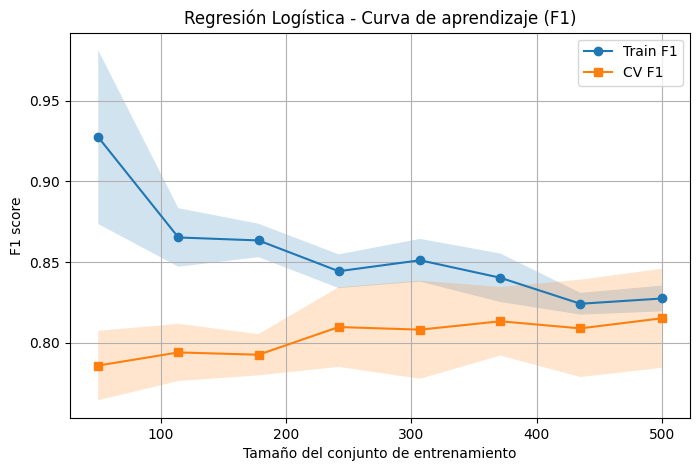

In [27]:
#Representación de datos, Importamos matplotlib y la curva de aprendizaje
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Montamos los valores para graficar
train_sizes, train_scores, val_scores = learning_curve(
    logreg_clf,
    X_train_full,
    y_train_full,
    cv=cv,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Imprimimos las gráficas
plt.figure(figsize=(8, 5))
plt.title("Regresión Logística - Curva de aprendizaje (F1)")
plt.plot(train_sizes, train_mean, marker='o', label='Train F1')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, marker='s', label='CV F1')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("F1 score")
plt.grid(True)
plt.legend()
plt.show()


# Decision Tree

In [28]:
# Importamos DecisionTree
from sklearn.tree import DecisionTreeClassifier

def make_dt_reg():
    return DecisionTreeClassifier(
        criterion='gini',
        max_depth=9,          # igual que tu versión regularizada
        min_samples_leaf=25,
        min_samples_split=30,
        class_weight='balanced',
        random_state=42
    )

best_model_dt = None
best_f1_val_dt = -1.0
fold_results_dt = []

print("=== Decision Tree REGULARIZADO - Validación cruzada manual (5 folds) ===")

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_full, y_train_full), start=1):
    X_tr, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_tr, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

    model = make_dt_reg()
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_val_pred)
    rec = recall_score(y_val, y_val_pred)
    f1  = f1_score(y_val, y_val_pred)
    roc = roc_auc_score(y_val, y_val_proba)

    fold_results_dt.append((acc, rec, f1, roc))

    print(f"\nFold {fold}:")
    print(f"  Accuracy: {acc:.3f}")
    print(f"  Recall:   {rec:.3f}")
    print(f"  F1:       {f1:.3f}")
    print(f"  ROC AUC:  {roc:.3f}")

    # Nos quedamos con el mejor fold según F1
    if f1 > best_f1_val_dt:
        best_f1_val_dt = f1
        best_model_dt = model

# Promedios de CV
fold_results_dt = np.array(fold_results_dt)
mean_acc_dt, mean_rec_dt, mean_f1_dt, mean_roc_dt = fold_results_dt.mean(axis=0)
std_acc_dt, std_rec_dt, std_f1_dt, std_roc_dt = fold_results_dt.std(axis=0)

print("\n=== Decision Tree REGULARIZADO - Resultados CV (5 folds, promedio) ===")
print(f"Accuracy: {mean_acc_dt:.3f} ± {std_acc_dt:.3f}")
print(f"Recall:   {mean_rec_dt:.3f} ± {std_rec_dt:.3f}")
print(f"F1:       {mean_f1_dt:.3f} ± {std_f1_dt:.3f}")
print(f"ROC AUC:  {mean_roc_dt:.3f} ± {std_roc_dt:.3f}")

print(f"\nMejor F1 de validación en un solo fold (DT): {best_f1_val_dt:.3f}")


=== Decision Tree REGULARIZADO - Validación cruzada manual (5 folds) ===

Fold 1:
  Accuracy: 0.936
  Recall:   1.000
  F1:       0.923
  ROC AUC:  0.967

Fold 2:
  Accuracy: 0.920
  Recall:   0.979
  F1:       0.904
  ROC AUC:  0.942

Fold 3:
  Accuracy: 0.904
  Recall:   1.000
  F1:       0.891
  ROC AUC:  0.960

Fold 4:
  Accuracy: 0.904
  Recall:   1.000
  F1:       0.891
  ROC AUC:  0.960

Fold 5:
  Accuracy: 0.944
  Recall:   1.000
  F1:       0.933
  ROC AUC:  0.979

=== Decision Tree REGULARIZADO - Resultados CV (5 folds, promedio) ===
Accuracy: 0.922 ± 0.016
Recall:   0.996 ± 0.008
F1:       0.908 ± 0.017
ROC AUC:  0.962 ± 0.012

Mejor F1 de validación en un solo fold (DT): 0.933


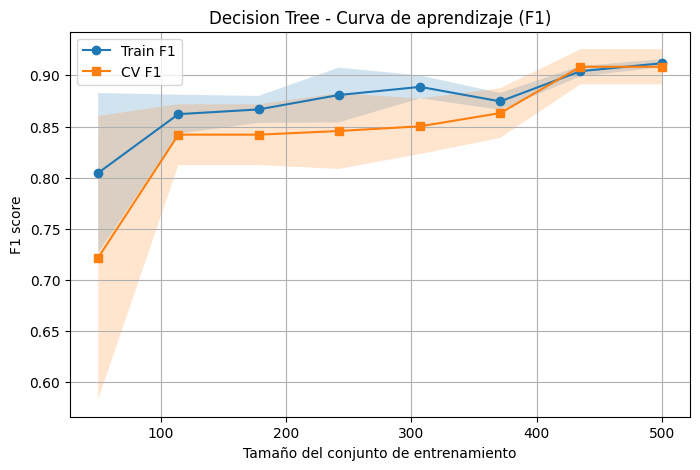

In [32]:
#Nuevamente montamos los datos para graficar
dt_clf_reg = make_dt_reg()
train_sizes_dt, train_scores_dt, val_scores_dt = learning_curve(
    dt_clf_reg,
    X_train_full,
    y_train_full,
    cv=cv,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)

train_mean_dt = train_scores_dt.mean(axis=1)
train_std_dt = train_scores_dt.std(axis=1)
val_mean_dt = val_scores_dt.mean(axis=1)
val_std_dt = val_scores_dt.std(axis=1)

#Gráfica
plt.figure(figsize=(8, 5))
plt.title("Decision Tree - Curva de aprendizaje (F1)")
plt.plot(train_sizes_dt, train_mean_dt, marker='o', label='Train F1')
plt.fill_between(train_sizes_dt, train_mean_dt - train_std_dt, train_mean_dt + train_std_dt, alpha=0.2)
plt.plot(train_sizes_dt, val_mean_dt, marker='s', label='CV F1')
plt.fill_between(train_sizes_dt, val_mean_dt - val_std_dt, val_mean_dt + val_std_dt, alpha=0.2)
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("F1 score")
plt.grid(True)
plt.legend()
plt.show()


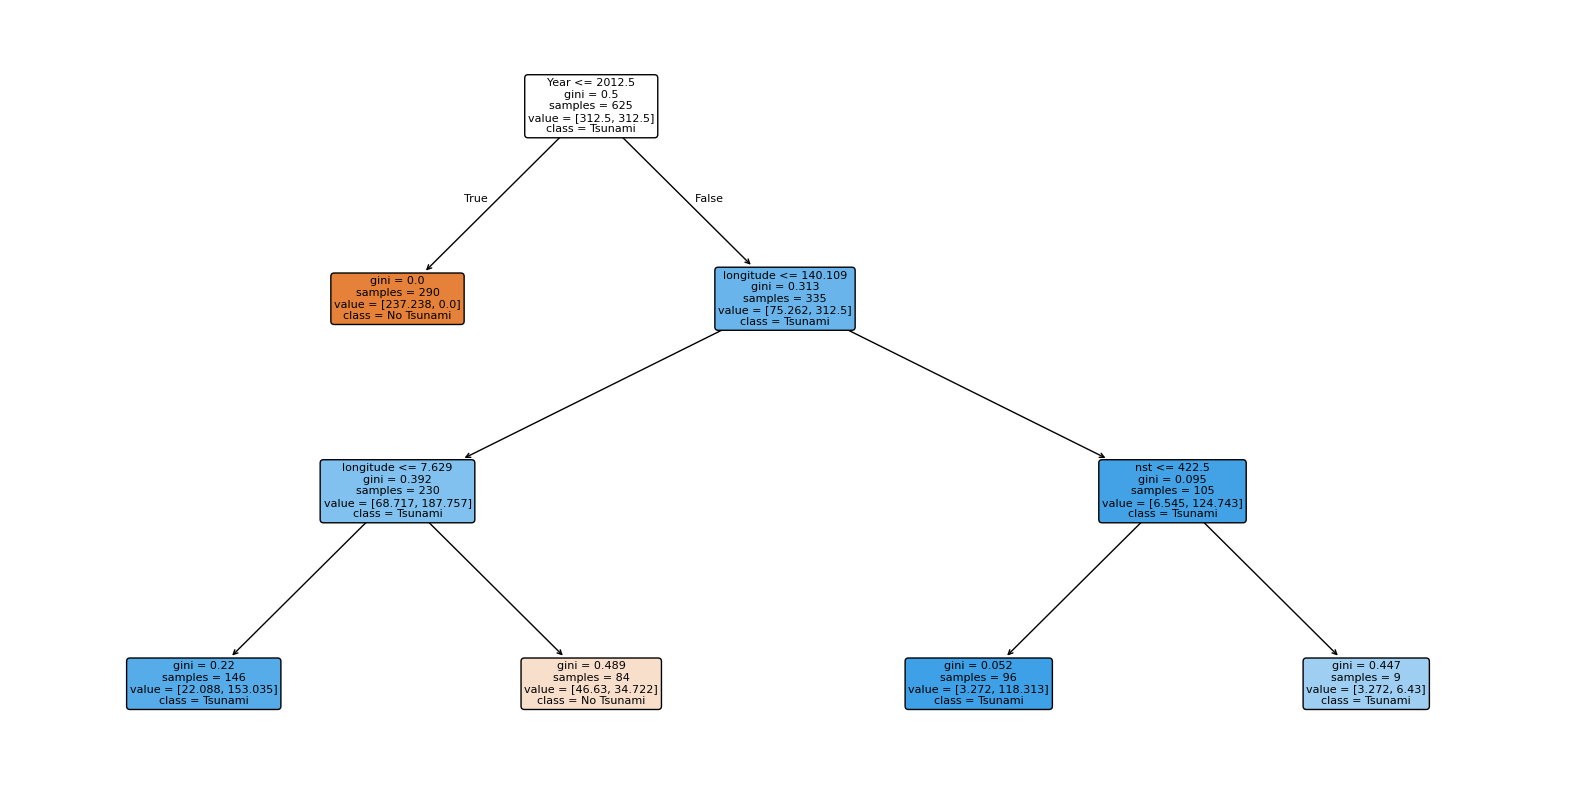

In [33]:
#Y ploteamos el tree para ver las variables

from sklearn.tree import plot_tree

dt_viz = DecisionTreeClassifier(
    criterion='gini',
    max_depth=3,
    class_weight='balanced',
    random_state=42
)
dt_viz.fit(X_train_full, y_train_full)

plt.figure(figsize=(20, 10))
plot_tree(
    dt_viz,
    feature_names=X.columns,
    class_names=['No Tsunami', 'Tsunami'],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()


#Random Forest

In [34]:
#Importamos las librerías de RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score


def make_rf():
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )

best_model_rf = None
best_f1_val = -1.0
fold_results = []


print("=== Random Forest - Validación cruzada manual (5 folds) ===")

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_full, y_train_full), start=1):
    X_tr, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_tr, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

    model = make_rf()
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_val_pred)
    rec = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    roc = roc_auc_score(y_val, y_val_proba)

    fold_results.append((acc, rec, f1, roc))

    print(f"\nFold {fold}:")
    print(f"  Accuracy: {acc:.3f}")
    print(f"  Recall:   {rec:.3f}")
    print(f"  F1:       {f1:.3f}")
    print(f"  ROC AUC:  {roc:.3f}")

 # Nos quedamos con el mejor fold
    if f1 > best_f1_val:
        best_f1_val = f1
        best_model_rf = model

# Promedios de CV
fold_results = np.array(fold_results)
mean_acc, mean_rec, mean_f1, mean_roc = fold_results.mean(axis=0)
std_acc, std_rec, std_f1, std_roc = fold_results.std(axis=0)

print("\n=== Random Forest - Resultados CV (5 folds, promedio) ===")
print(f"Accuracy: {mean_acc:.3f} ± {std_acc:.3f}")
print(f"Recall:   {mean_rec:.3f} ± {std_rec:.3f}")
print(f"F1:       {mean_f1:.3f} ± {std_f1:.3f}")
print(f"ROC AUC:  {mean_roc:.3f} ± {std_roc:.3f}")

print(f"\nMejor F1 de validación en un solo fold: {best_f1_val:.3f}")


=== Random Forest - Validación cruzada manual (5 folds) ===

Fold 1:
  Accuracy: 0.928
  Recall:   0.958
  F1:       0.911
  ROC AUC:  0.978

Fold 2:
  Accuracy: 0.912
  Recall:   0.917
  F1:       0.889
  ROC AUC:  0.969

Fold 3:
  Accuracy: 0.896
  Recall:   0.959
  F1:       0.879
  ROC AUC:  0.960

Fold 4:
  Accuracy: 0.888
  Recall:   0.939
  F1:       0.868
  ROC AUC:  0.957

Fold 5:
  Accuracy: 0.960
  Recall:   1.000
  F1:       0.951
  ROC AUC:  0.988

=== Random Forest - Resultados CV (5 folds, promedio) ===
Accuracy: 0.917 ± 0.026
Recall:   0.955 ± 0.028
F1:       0.900 ± 0.030
ROC AUC:  0.970 ± 0.011

Mejor F1 de validación en un solo fold: 0.951


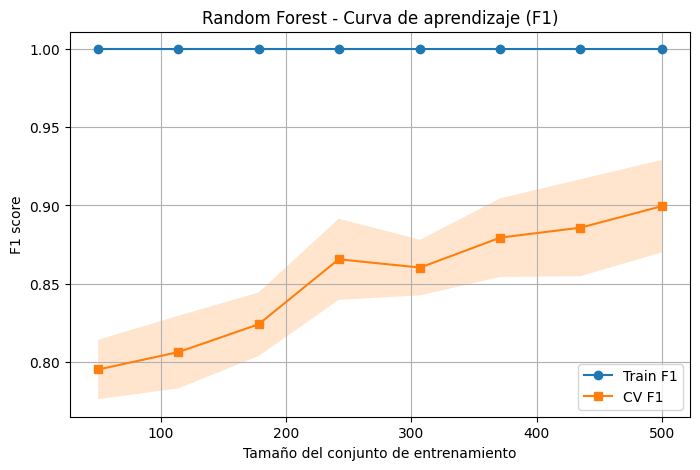

In [35]:
#Graficamos la curva de aprendizaje
train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
    best_model_rf,
    X_train_full,
    y_train_full,
    cv=cv,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)

train_mean_rf = train_scores_rf.mean(axis=1)
train_std_rf = train_scores_rf.std(axis=1)
val_mean_rf = val_scores_rf.mean(axis=1)
val_std_rf = val_scores_rf.std(axis=1)

plt.figure(figsize=(8, 5))
plt.title("Random Forest - Curva de aprendizaje (F1)")
plt.plot(train_sizes_rf, train_mean_rf, marker='o', label='Train F1')
plt.fill_between(train_sizes_rf, train_mean_rf - train_std_rf, train_mean_rf + train_std_rf, alpha=0.2)
plt.plot(train_sizes_rf, val_mean_rf, marker='s', label='CV F1')
plt.fill_between(train_sizes_rf, val_mean_rf - val_std_rf, val_mean_rf + val_std_rf, alpha=0.2)
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("F1 score")
plt.grid(True)
plt.legend()
plt.show()


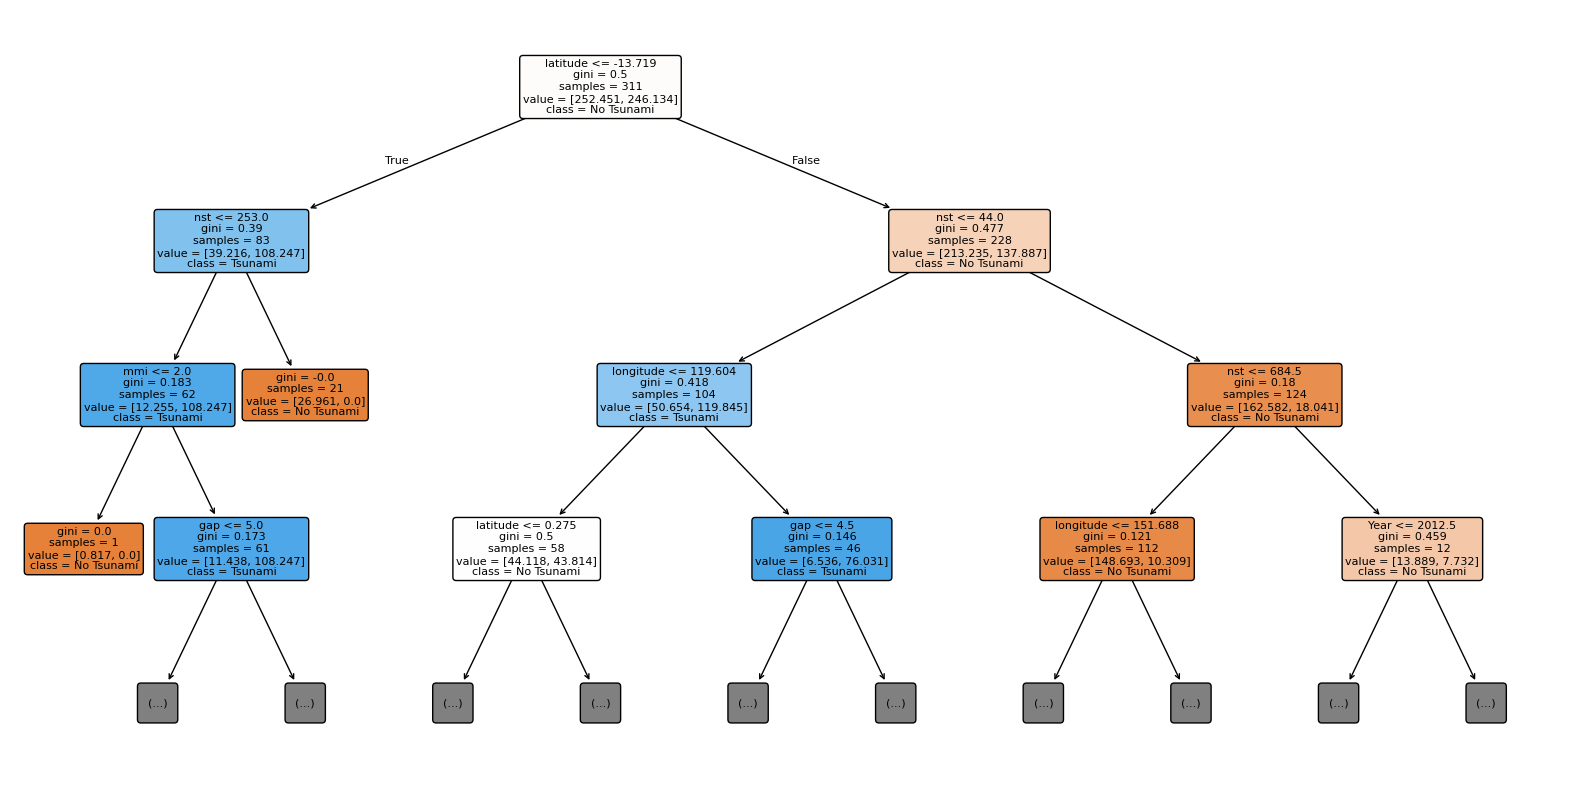

In [36]:
from sklearn.tree import plot_tree

# Elegimos un árbol del Random Forest ya entrenado (por ejemplo, el primero)
one_tree = best_model_rf.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(
    one_tree,
    feature_names=X.columns,
    class_names=['No Tsunami', 'Tsunami'],
    filled=True,
    rounded=True,
    max_depth=3,   # para que no sea un monstruo ilegible
    fontsize=8
)
plt.show()


#Prueba final en los datos de Test


In [37]:
from sklearn.metrics import classification_report, confusion_matrix

# Realizamos el test con el modelo final
y_test_pred = best_model_rf.predict(X_test)
y_test_proba = best_model_rf.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_test_pred)
rec_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
roc_test = roc_auc_score(y_test, y_test_proba)

print("=== Random Forest - Resultados en TEST (20%) ===")
print(f"Accuracy: {acc_test:.3f}")
print(f"Recall:   {rec_test:.3f}")
print(f"F1:       {f1_test:.3f}")
print(f"ROC AUC:  {roc_test:.3f}")

print("\nMatriz de confusión (TEST):")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification report (TEST):")
print(classification_report(y_test, y_test_pred, target_names=['No Tsunami', 'Tsunami']))


=== Random Forest - Resultados en TEST (20%) ===
Accuracy: 0.936
Recall:   0.967
F1:       0.922
ROC AUC:  0.964

Matriz de confusión (TEST):
[[88  8]
 [ 2 59]]

Classification report (TEST):
              precision    recall  f1-score   support

  No Tsunami       0.98      0.92      0.95        96
     Tsunami       0.88      0.97      0.92        61

    accuracy                           0.94       157
   macro avg       0.93      0.94      0.93       157
weighted avg       0.94      0.94      0.94       157

